In [1]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from random import seed
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import shap
tf.compat.v1.experimental.output_all_intermediates(True)

In [2]:
tf.random.set_seed(36)

## Dataset

In [3]:
BASE_DIR_PATH = '../Datasets'
DATASET_FILE = os.path.join(BASE_DIR_PATH, '2016_2017_sto_nino_and_montalban.csv')

In [4]:
df = pd.read_csv(DATASET_FILE)
df

,Unnamed: 0,datetime,month,day,hour,t,Station,x,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel,Discharge,Cross_Section,Velocity,fric_coeff,slope
0,0,2016-01-01 00:00:00,1,1,0,0.0,Montalban,0,0,1,2,0,0,21.03,14.842428,630.90,0.023526,0.035,0.002000
1,1,2016-01-01 00:00:00,1,1,0,0.0,Sto_Nino,14420,0,1,2,0,0,12.18,21.033407,803.88,0.026165,0.033,0.000667
2,2,2016-01-01 01:00:00,1,1,1,3600.0,Montalban,0,0,1,1,1,0,21.03,14.842428,630.90,0.023526,0.035,0.002000
3,3,2016-01-01 01:00:00,1,1,1,3600.0,Sto_Nino,14420,0,1,1,1,0,12.19,21.280072,804.54,0.026450,0.033,0.000667
4,4,2016-01-01 02:00:00,1,1,2,7200.0,Montalban,0,1,1,1,0,1,21.03,14.842428,630.90,0.023526,0.035,0.002000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,35035,2017-12-31 21:00:00,12,31,21,63147600.0,Sto_Nino,14420,0,0,0,0,0,12.44,28.244204,821.04,0.034401,0.033,0.000667
35036,35036,2017-12-31 22:00:00,12,31,22,63151200.0,Montalban,0,0,0,0,0,0,21.18,17.224575,635.40,0.027108,0.035,0.002000
35037,35037,2017-12-31 22:00:00,12,31,22,63151200.0,Sto_Nino,14420,0,0,0,0,0,12.44,28.244204,821.04,0.034401,0.033,0.000667
35038,35038,2017-12-31 23:00:00,12,31,23,63154800.0,Montalban,0,0,0,0,0,0,21.18,17.224575,635.40,0.027108,0.035,0.002000


In [5]:
df = df[['month', 'day', 'hour', 'Station', 'Rainfall_Aries', 'Rainfall_Boso', 'Rainfall_Campana', 'Rainfall_Nangka', 'Rainfall_Oro', 'Waterlevel']]
df

,month,day,hour,Station,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel
0,1,1,0,Montalban,0,1,2,0,0,21.03
1,1,1,0,Sto_Nino,0,1,2,0,0,12.18
2,1,1,1,Montalban,0,1,1,1,0,21.03
3,1,1,1,Sto_Nino,0,1,1,1,0,12.19
4,1,1,2,Montalban,1,1,1,0,1,21.03
...,...,...,...,...,...,...,...,...,...,...
35035,12,31,21,Sto_Nino,0,0,0,0,0,12.44
35036,12,31,22,Montalban,0,0,0,0,0,21.18
35037,12,31,22,Sto_Nino,0,0,0,0,0,12.44
35038,12,31,23,Montalban,0,0,0,0,0,21.18


In [6]:
df['Station'] = [1 if x == 'Sto_Nino' else 0 for x in df['Station']]
df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,month,day,hour,Station,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel
0,1,1,0,0,0,1,2,0,0,21.03
1,1,1,0,1,0,1,2,0,0,12.18
2,1,1,1,0,0,1,1,1,0,21.03
3,1,1,1,1,0,1,1,1,0,12.19
4,1,1,2,0,1,1,1,0,1,21.03
...,...,...,...,...,...,...,...,...,...,...
35035,12,31,21,1,0,0,0,0,0,12.44
35036,12,31,22,0,0,0,0,0,0,21.18
35037,12,31,22,1,0,0,0,0,0,12.44
35038,12,31,23,0,0,0,0,0,0,21.18


## Window Generator

In [7]:
sto_nino_df = df[df['Station'] == 1]
sto_nino_df

,month,day,hour,Station,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel
1,1,1,0,1,0,1,2,0,0,12.18
3,1,1,1,1,0,1,1,1,0,12.19
5,1,1,2,1,1,1,1,0,1,12.19
7,1,1,3,1,0,0,0,1,0,12.20
9,1,1,4,1,1,1,1,0,0,12.20
...,...,...,...,...,...,...,...,...,...,...
35031,12,31,19,1,0,0,0,0,0,12.44
35033,12,31,20,1,0,0,0,0,0,12.44
35035,12,31,21,1,0,0,0,0,0,12.44
35037,12,31,22,1,0,0,0,0,0,12.44


In [8]:
n = len(sto_nino_df)

In [9]:
sto_nino_train_df = sto_nino_df[0:int(n*0.5)]
sto_nino_val_df = sto_nino_df[int(n*0.5):int(n*0.75)]
sto_nino_test_df = sto_nino_df[int(n*0.75):]

In [10]:
sto_nino_train_df.shape

(8760, 10)

In [11]:
sto_nino_val_df.shape

(4380, 10)

In [12]:
sto_nino_test_df.shape

(4380, 10)

In [13]:
montalban_df = df[df['Station'] == 0]
montalban_df

,month,day,hour,Station,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel
0,1,1,0,0,0,1,2,0,0,21.03
2,1,1,1,0,0,1,1,1,0,21.03
4,1,1,2,0,1,1,1,0,1,21.03
6,1,1,3,0,0,0,0,1,0,21.03
8,1,1,4,0,1,1,1,0,0,21.03
...,...,...,...,...,...,...,...,...,...,...
35030,12,31,19,0,0,0,0,0,0,21.18
35032,12,31,20,0,0,0,0,0,0,21.18
35034,12,31,21,0,0,0,0,0,0,21.18
35036,12,31,22,0,0,0,0,0,0,21.18


In [14]:
montalban_train_df = montalban_df[0:int(n*0.5)]
montalban_val_df = montalban_df[int(n*0.5):int(n*0.75)]
montalban_test_df = montalban_df[int(n*0.75):]

In [15]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df, val_df, test_df, label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    # Creating tf datasets for more convenient use and integration into model in the future
    def make_dataset(self, data, shuffle=True):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=shuffle,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    # properties to access them as tf datasets
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df, False)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

### possible hyperparam: # of consecutive hours taken together

In [16]:
CONSECUTIVE_HOURS = 6

In [17]:
sto_nino_window = WindowGenerator(
        input_width=CONSECUTIVE_HOURS, label_width=1, shift=1,
        train_df = sto_nino_train_df,
        val_df = sto_nino_val_df,
        test_df = sto_nino_test_df,
        label_columns=['Waterlevel']
    )

sto_nino_window 

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Waterlevel']

In [18]:
montalban_window = WindowGenerator(
        input_width=CONSECUTIVE_HOURS, label_width=1, shift=1,
        train_df = montalban_train_df,
        val_df = montalban_val_df,
        test_df = montalban_test_df,
        label_columns=['Waterlevel']
    )

montalban_window 

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Waterlevel']

In [19]:
train_ds = sto_nino_window.train.concatenate(montalban_window.train)
train_ds = train_ds.shuffle(buffer_size=len(list(train_ds)))

val_ds = sto_nino_window.val.concatenate(montalban_window.val)
val_ds = val_ds.shuffle(buffer_size=len(list(val_ds)))

## Evaluation Metrics

In [20]:
def r_square(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.square(K.sum(xm * ym))
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = (x_square_sum * y_square_sum) + K.epsilon()
    
    r = r_num / r_den
    return r

In [21]:
def NSE(y_true, y_pred):
    '''
    This is the Nash-Sutcliffe Efficiency Coefficient
    '''
    y_pred = K.flatten(y_pred)
    y_true = K.flatten(y_true)

    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Training

In [22]:
# For easy compiling and fitting of different models
MAX_EPOCHS = 20

def compile_and_fit(model, train_data=train_ds, val_data=val_ds, patience=2, lr=0.001):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', restore_best_weights=True)

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(), 
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
        metrics=[tf.keras.metrics.MeanSquaredError(), NSE, r_square]
    )

    history = model.fit(
        train_data, 
        epochs=MAX_EPOCHS,
        validation_data=val_data,
        callbacks=[early_stopping]
    )

    return history

In [23]:
def create_dense_model(n1=64, n2=64, n3=64):
    dense = tf.keras.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=n1, activation='relu'),
        tf.keras.layers.Dense(units=n2, activation='relu'),
        tf.keras.layers.Dense(units=n3, activation='relu'),
        tf.keras.layers.Dense(units=1),
        tf.keras.layers.Reshape([1,-1])
    ])
    
    return dense

In [24]:
def create_conv_model(n1=64, n2=64, n3=64):
    conv_model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=n1, kernel_size=(CONSECUTIVE_HOURS,), activation='relu'),
        tf.keras.layers.Dense(units=n2, activation='relu'),
        tf.keras.layers.Dense(units=n3, activation='relu'),
        tf.keras.layers.Dense(units=1),
    ])
    
    return conv_model

In [25]:
def create_lstm_model(n1=64, n2=64, n3=64):
    lstm_model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(n1, return_sequences=False),
        tf.keras.layers.Dense(units=n2, activation='relu'),
        tf.keras.layers.Dense(units=n3, activation='relu'),
        tf.keras.layers.Dense(units=1)
    ])
    
    return lstm_model

In [26]:
dense = create_dense_model()
dense_history = compile_and_fit(dense)

Epoch 1/20
548/548 [==============================] - 4s 3ms/step - loss: 2.1832 - mean_squared_error: 2.1832 - NSE: -6.5034 - r_square: 0.6355 - val_loss: 0.0708 - val_mean_squared_error: 0.0708 - val_NSE: -4.0164 - val_r_square: 0.4408
Epoch 2/20
548/548 [==============================] - 2s 2ms/step - loss: 0.1033 - mean_squared_error: 0.1033 - NSE: 0.8012 - r_square: 0.8813 - val_loss: 0.0473 - val_mean_squared_error: 0.0473 - val_NSE: -2.1431 - val_r_square: 0.5216
Epoch 3/20
548/548 [==============================] - 2s 2ms/step - loss: 0.0969 - mean_squared_error: 0.0969 - NSE: 0.8143 - r_square: 0.9053 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - val_NSE: -1.0879 - val_r_square: 0.6192
Epoch 4/20
548/548 [==============================] - 2s 2ms/step - loss: 0.1014 - mean_squared_error: 0.1014 - NSE: 0.7950 - r_square: 0.9145 - val_loss: 0.0961 - val_mean_squared_error: 0.0961 - val_NSE: -7.1273 - val_r_square: 0.6057
Epoch 5/20
548/548 [==============================]

In [27]:
conv_model = create_conv_model()
conv_history = compile_and_fit(conv_model)

Epoch 1/20
548/548 [==============================] - 3s 3ms/step - loss: 5.5738 - mean_squared_error: 5.5738 - NSE: -19.4218 - r_square: 0.6839 - val_loss: 0.0497 - val_mean_squared_error: 0.0497 - val_NSE: -2.0957 - val_r_square: 0.4716
Epoch 2/20
548/548 [==============================] - 2s 2ms/step - loss: 0.0883 - mean_squared_error: 0.0883 - NSE: 0.8324 - r_square: 0.9038 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_NSE: -0.4896 - val_r_square: 0.6163
Epoch 3/20
548/548 [==============================] - 2s 2ms/step - loss: 0.0797 - mean_squared_error: 0.0797 - NSE: 0.8561 - r_square: 0.9246 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_NSE: -0.5203 - val_r_square: 0.6678
Epoch 4/20
548/548 [==============================] - 2s 2ms/step - loss: 0.0819 - mean_squared_error: 0.0819 - NSE: 0.8463 - r_square: 0.9308 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - val_NSE: -8.1468 - val_r_square: 0.6340
Epoch 5/20
548/548 [==============================

In [28]:
lstm_model = create_lstm_model()
lstm_history = compile_and_fit(lstm_model)

Epoch 1/20
548/548 [==============================] - 6s 6ms/step - loss: 17.5881 - mean_squared_error: 17.5881 - NSE: -42.2352 - r_square: 0.5350 - val_loss: 0.0734 - val_mean_squared_error: 0.0734 - val_NSE: -5.1431 - val_r_square: 0.3364
Epoch 2/20
548/548 [==============================] - 3s 5ms/step - loss: 0.1021 - mean_squared_error: 0.1021 - NSE: 0.7947 - r_square: 0.8756 - val_loss: 0.0549 - val_mean_squared_error: 0.0549 - val_NSE: -3.9904 - val_r_square: 0.4739
Epoch 3/20
548/548 [==============================] - 3s 5ms/step - loss: 0.1397 - mean_squared_error: 0.1397 - NSE: 0.7007 - r_square: 0.8754 - val_loss: 0.0615 - val_mean_squared_error: 0.0615 - val_NSE: -3.9631 - val_r_square: 0.5060
Epoch 4/20
548/548 [==============================] - 3s 5ms/step - loss: 0.0961 - mean_squared_error: 0.0961 - NSE: 0.8042 - r_square: 0.9136 - val_loss: 0.0834 - val_mean_squared_error: 0.0834 - val_NSE: -1.9117 - val_r_square: 0.4803


## Predictions

### sto nino

In [29]:
sto_nino_test_df

,month,day,hour,Station,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel
26281,7,2,12,1,0,0,0,0,0,11.89
26283,7,2,13,1,0,0,0,0,0,11.87
26285,7,2,14,1,0,0,0,0,0,11.85
26287,7,2,15,1,0,4,0,0,0,11.84
26289,7,2,16,1,11,19,0,22,0,11.84
...,...,...,...,...,...,...,...,...,...,...
35031,12,31,19,1,0,0,0,0,0,12.44
35033,12,31,20,1,0,0,0,0,0,12.44
35035,12,31,21,1,0,0,0,0,0,12.44
35037,12,31,22,1,0,0,0,0,0,12.44


In [30]:
sto_nino_y_true = sto_nino_test_df['Waterlevel']
sto_nino_y_true = sto_nino_y_true.values
sto_nino_y_true = sto_nino_y_true[CONSECUTIVE_HOURS:]
sto_nino_y_true

array([12.63, 12.81, 12.8 , ..., 12.44, 12.44, 12.44])

In [31]:
sto_nino_y_true.shape

(4374,)

In [32]:
np.set_printoptions(suppress=True)

In [33]:
for x, y in sto_nino_window.test.take(1):
    print(x[:5])
    print(y[:5])
    print(lstm_model(x[:5]))
    break

tf.Tensor(
[[[ 7.    2.   12.    1.    0.    0.    0.    0.    0.   11.89]
  [ 7.    2.   13.    1.    0.    0.    0.    0.    0.   11.87]
  [ 7.    2.   14.    1.    0.    0.    0.    0.    0.   11.85]
  [ 7.    2.   15.    1.    0.    4.    0.    0.    0.   11.84]
  [ 7.    2.   16.    1.   11.   19.    0.   22.    0.   11.84]
  [ 7.    2.   17.    1.    4.   17.   15.    1.    4.   12.26]]

 [[ 7.    2.   13.    1.    0.    0.    0.    0.    0.   11.87]
  [ 7.    2.   14.    1.    0.    0.    0.    0.    0.   11.85]
  [ 7.    2.   15.    1.    0.    4.    0.    0.    0.   11.84]
  [ 7.    2.   16.    1.   11.   19.    0.   22.    0.   11.84]
  [ 7.    2.   17.    1.    4.   17.   15.    1.    4.   12.26]
  [ 7.    2.   18.    1.    1.    1.    0.    2.    1.   12.63]]

 [[ 7.    2.   14.    1.    0.    0.    0.    0.    0.   11.85]
  [ 7.    2.   15.    1.    0.    4.    0.    0.    0.   11.84]
  [ 7.    2.   16.    1.   11.   19.    0.   22.    0.   11.84]
  [ 7.    2.   17.    1. 

In [34]:
sto_nino_y_pred = []

for x, _ in sto_nino_window.test:
    predictions = lstm_model(x)
    for i in range(len(predictions)):
        sto_nino_y_pred.append(predictions[i])
    
sto_nino_y_pred = np.array(sto_nino_y_pred).reshape(sto_nino_y_true.shape)

In [35]:
sto_nino_y_pred

array([12.742152, 11.998496, 12.299852, ..., 12.233313, 12.221055,
       12.155423], dtype=float32)

In [36]:
sto_nino_y_pred.shape

(4374,)

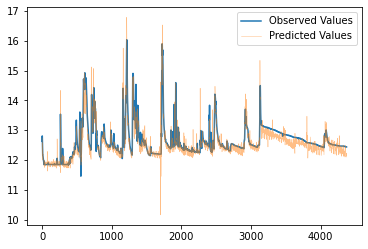

In [37]:
plt.plot(sto_nino_y_true, label='Observed Values')
plt.plot(sto_nino_y_pred, label='Predicted Values', alpha=0.5, linewidth=0.5)
plt.legend()
plt.show()

In [38]:
SS_res = np.sum(np.square(sto_nino_y_true - sto_nino_y_pred)) 
SS_tot = np.sum(np.square(sto_nino_y_true - np.mean(sto_nino_y_true))) 

sto_nino_nse =  1 - SS_res/SS_tot
sto_nino_nse

0.8117124506473878

In [39]:
sto_nino_mse = np.mean(np.square(sto_nino_y_true-sto_nino_y_pred))
sto_nino_mse

0.05840280693970912

### montalban

In [40]:
montalban_test_df

,month,day,hour,Station,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel
26280,7,2,12,0,0,0,0,0,0,21.26
26282,7,2,13,0,0,0,0,0,0,21.26
26284,7,2,14,0,0,0,0,0,0,21.25
26286,7,2,15,0,0,4,0,0,0,21.24
26288,7,2,16,0,11,19,0,22,0,21.00
...,...,...,...,...,...,...,...,...,...,...
35030,12,31,19,0,0,0,0,0,0,21.18
35032,12,31,20,0,0,0,0,0,0,21.18
35034,12,31,21,0,0,0,0,0,0,21.18
35036,12,31,22,0,0,0,0,0,0,21.18


In [41]:
montalban_y_true = montalban_test_df['Waterlevel']
montalban_y_true = montalban_y_true.values
montalban_y_true = montalban_y_true[CONSECUTIVE_HOURS:]
montalban_y_true

array([21.33, 21.34, 21.34, ..., 21.18, 21.18, 21.18])

In [42]:
for x, y in montalban_window.test.take(1):
    print(x[:2])
    print(y[:2])
    print(lstm_model(x[:2]))
    break

tf.Tensor(
[[[ 7.    2.   12.    0.    0.    0.    0.    0.    0.   21.26]
  [ 7.    2.   13.    0.    0.    0.    0.    0.    0.   21.26]
  [ 7.    2.   14.    0.    0.    0.    0.    0.    0.   21.25]
  [ 7.    2.   15.    0.    0.    4.    0.    0.    0.   21.24]
  [ 7.    2.   16.    0.   11.   19.    0.   22.    0.   21.  ]
  [ 7.    2.   17.    0.    4.   17.   15.    1.    4.   21.28]]

 [[ 7.    2.   13.    0.    0.    0.    0.    0.    0.   21.26]
  [ 7.    2.   14.    0.    0.    0.    0.    0.    0.   21.25]
  [ 7.    2.   15.    0.    0.    4.    0.    0.    0.   21.24]
  [ 7.    2.   16.    0.   11.   19.    0.   22.    0.   21.  ]
  [ 7.    2.   17.    0.    4.   17.   15.    1.    4.   21.28]
  [ 7.    2.   18.    0.    1.    1.    0.    2.    1.   21.33]]], shape=(2, 6, 10), dtype=float32)
tf.Tensor(
[[[21.33]]

 [[21.34]]], shape=(2, 1, 1), dtype=float32)
tf.Tensor(
[[21.47705 ]
 [20.653767]], shape=(2, 1), dtype=float32)


In [43]:
montalban_y_pred = []
batch_num = 1

for x, y in montalban_window.test:
    predictions = lstm_model(x)
    for i in range(len(predictions)):
        montalban_y_pred.append(predictions[i])
    
montalban_y_pred = np.array(montalban_y_pred).reshape(montalban_y_true.shape)

In [44]:
montalban_y_pred

array([21.47705 , 20.653767, 20.737629, ..., 21.294674, 21.221981,
       21.13277 ], dtype=float32)

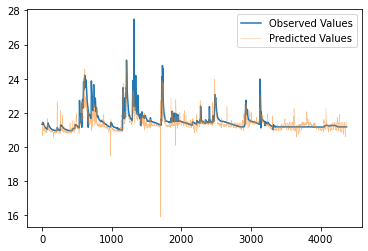

In [45]:
plt.plot(montalban_y_true, label='Observed Values')
plt.plot(montalban_y_pred, label='Predicted Values', alpha=0.5, linewidth=0.5)
plt.legend()
plt.show()

In [46]:
SS_res = np.sum(np.square(montalban_y_true - montalban_y_pred)) 
SS_tot = np.sum(np.square(montalban_y_true - np.mean(montalban_y_true))) 

montalban_nse =  1 - SS_res/SS_tot
montalban_nse

0.5973967571514989

In [47]:
montalban_mse = np.mean(np.square(montalban_y_true-montalban_y_pred))
montalban_mse

0.122544942613982

In [48]:
mse = (sto_nino_mse + montalban_mse)/2
nse = (sto_nino_nse + montalban_nse)/2

mse, nse

(0.09047387477684556, 0.7045546038994434)

In [49]:
np.savetxt(f'results/window_lag{CONSECUTIVE_HOURS}_sto_nino.csv', sto_nino_y_pred, delimiter=',', fmt='%.4f')

In [50]:
np.savetxt(f'results/window_lag{CONSECUTIVE_HOURS}_montalban.csv', montalban_y_pred, delimiter=',', fmt='%.4f')